# Coupled FHN model

In this notebook we want to explore coupled, excitable FitzHugh-Nagumo systems. First, in the context of spatial neares-neighbour, diffusion-like coupling of cells in the heart. And second, coupled on a random, directed network like neurons in the brain.

The general model is composed of two variables at each cell $i$, the (fast) activator $u_i$ and the inhibitor $v_i$, and reads

$$
\dot{u}_i=\alpha u_i (u_i-\beta)(1-u_i) - v_i  + \sum_{j}G_{ij}u_j+\eta_i\\
\dot{v}_i=\epsilon(u_i-v_i),
$$
where $\eta_i$ is a Gaussian noise that we only apply for the brain dynamics. 
Note that the parameters $\alpha$, $\beta$, and $\epsilon$ are homogeneous across cells, and the (spatial) coupling is only mediated via the acivators $u_i$.

In [3]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import lil_matrix, diags
import sdeint as sde

import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5
import diffrax
import jax
from jax.experimental import sparse

In [2]:
## Run only if you have installed jax with cuda and there is a GPU in your machine but you anyway want to use the CPU instead 
jax.config.update('jax_platform_name', 'cpu')
# before execute any computation / allocation
print(jax.numpy.ones(3).device)

TFRT_CPU_0


## Nullclines and Parameter Exploration

In [115]:
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

import jax.numpy as jnp

# Define the FitzHugh-Nagumo system
def FHN(t, y, args):
    a, b, e = args
    u = y[0]
    v = y[1]
    du = a * u * (u - b) * (1 - u) - v
    dv = e * (u - v)
    return jnp.array([du, dv])

# Initial conditions
y0 = jnp.array([0.4, 0.0])

# Parameters
a = 3
b = 0.2
e = 0.01

# Time span
t1 = 10.0
t2 = 250.0

# Solve the ODE
term = ODETerm(FHN)
saveat = SaveAt(ts=jnp.linspace(0, t2, 1000))
solver = Tsit5()
sol = diffeqsolve(term, solver, t0=0, t1=t2, dt0=0.1, y0=y0, args=(a, b, e), saveat=saveat)
e=0.007
sol1 = diffeqsolve(term, solver, t0=0, t1=t2, dt0=0.1, y0=y0, args=(a, b, e), saveat=saveat)
e=0.05
sol2 = diffeqsolve(term, solver, t0=0, t1=t2, dt0=0.1, y0=y0, args=(a, b, e), saveat=saveat)


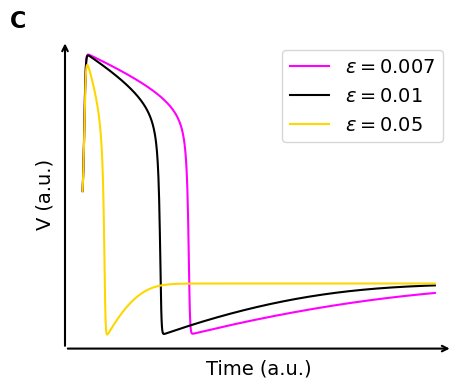

In [119]:

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.patch.set_alpha(0.0)

# Add arrows to the end of the spines
ax.annotate('', xy=(1, 0), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            xycoords=('axes fraction', 'axes fraction'), textcoords=('axes fraction', 'axes fraction'))
ax.annotate('', xy=(0, 1), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            xycoords=('axes fraction', 'axes fraction'), textcoords=('axes fraction', 'axes fraction'))

ax.plot(sol.ts, sol1.ys[:,0],label=r'$\epsilon=0.007$', color='magenta')
ax.plot(sol.ts,sol.ys[:,0],label=r'$\epsilon=0.01$', color='black')
ax.plot(sol.ts,sol2.ys[:,0],label=r'$\epsilon=0.05$', color='gold')
ax.set_xlabel('Time (a.u.)', fontsize=14)
ax.set_ylabel('V (a.u.)', fontsize=14)
ax.legend(fontsize=14)

For the parameters of the 1 cell system I found from the Parltz book:
aState space of the FitzHugh-Nagumo model (2.6) for a = 3, b = 0.2, I = 0 and ε = 0.01.
At the intersection of the nullclines nu (u) = au(u − b)(1 − u) (green dotted curve) and nw(u) = u
(orange dashed line) a stable fixed point(0, 0) exists. b A perturbation pushing the system state to an
initial condition at (0.19, 0) results in a trajectory that immediately returns to the fixed point (cyan
curve), while a perturbation above threshold (0.21, 0) leads to an excursion before the orbit (purple
curve) returns to the origin 
e For a = 8, b = 0.2, I = 0 and
ε = 0.01 the nullclines intersect at two points and the system is bistable. f With a = 3, b = −0.05,
I0 = 0 and ε = 0.01 the fixed point at the origin becomes unstable and a stable limit cycle occurs
(here shown as a purple trajectory starting at (0, 0.1) and converging to the periodic attractor)

(-0.6, 1.2)

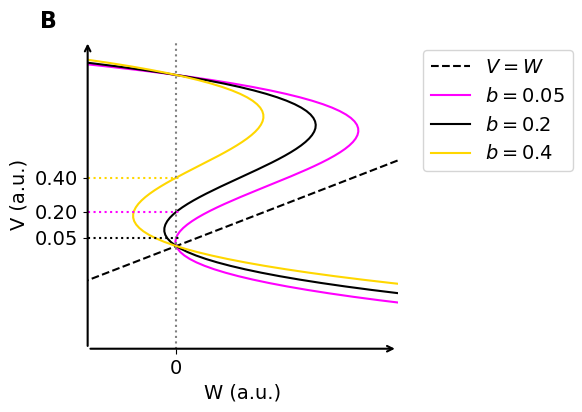

In [120]:
u_array = np.linspace(-1,3,200)
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.set_xticks([0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.patch.set_alpha(0.0)

# Add arrows to the end of the spines
ax.annotate('', xy=(1, 0), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            xycoords=('axes fraction', 'axes fraction'), textcoords=('axes fraction', 'axes fraction'))
ax.annotate('', xy=(0, 1), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            xycoords=('axes fraction', 'axes fraction'), textcoords=('axes fraction', 'axes fraction'))


ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax.plot(u_array,u_array, ls='--', c='black')
e = 1e-2 
a, b = (3, 0.2)
b1=0.05
b2=0.4
ax.set_yticks([b1,b,b2])
ax.plot(a*u_array*(u_array-b1)*(1-u_array), u_array, c='magenta')
ax.plot(a*u_array*(u_array-b)*(1-u_array), u_array, c='black')
ax.plot(a*u_array*(u_array-b2)*(1-u_array), u_array, c='gold')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.axvline(0, c='grey', ls=':')
ax.set_xlabel('W (a.u.)', fontsize=14)
ax.set_ylabel('V (a.u.)', fontsize=14)
ax.axhline(b, c='magenta', ls=':', xmax=0.3)
ax.axhline(b1, c='black', ls=':', xmax=0.3)
ax.axhline(b2, c='gold', ls=':', xmax=0.3)
ax.legend(['$V=W$','$b=0.05$','$b=0.2$','$b=0.4$'], fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(-0.2,.5)
ax.set_ylim(-.6,1.2)

# Spatial Coupling (🫀)

To model spatial signal propagation in the heart, we assume a nearest-neighbour coupling. I.e., for any cell $i^*$, the coupling matrix to its 8 nearest neighbours and itself reads
$$
G_{i^*j}\hat{=}\begin{bmatrix}
0.25 & 0.5 & 0.25 \\
0.25 & -3 & 0.5 \\
0.25 & 0.5 & 0.25 
\end{bmatrix},  
$$
which amounts to the Oono-Puri nince-point stencil of diffusion on a discrete lattice.

### Wave
Periodic boundary conditions, excitation in the middle.


In [5]:
def graph_laplacian(N,M, boundary_condition="periodic", sparse_matrix=True):

    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  # sparse adjacency matrix
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            # Connect to 8 neighbors (including diagonals), weights according to Oono-Puri
            neighbors = [
                (i - 1, j, .5),     # up
                (i + 1, j, .5),     # down
                (i, j - 1, .5),     # left
                (i, j + 1, .5),     # right
                (i - 1, j - 1, .25), # top-left
                (i - 1, j + 1, .25), # top-right
                (i + 1, j - 1, .25), # bottom-left
                (i + 1, j + 1, .25)  # bottom-right
            ]
            
            for ni, nj, w in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions
                    if 0 <= ni < N and 0 <= nj < M:
                        adj_matrix[idx, node_index(ni, nj)] = w
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = w

    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)
    
    # Laplacian: L = D - A
    laplacian_matrix = degree_matrix - adj_matrix
    #return laplacian_matrix
    #del degree_matrix
    #del adj_matrix
    if sparse_matrix:
        return sparse.BCSR.from_scipy_sparse(laplacian_matrix)
    else:
        return jnp.array(laplacian_matrix.todense())


N_x = 400
N_y = 400
N = N_x*N_y
sparse_matrix = True
L = graph_laplacian(N_x, N_y, sparse_matrix=sparse_matrix)
#if sparse_matrix: plt.imshow(L.todense())
#else: plt.imshow(L)
#plt.colorbar()


 Actually having a look at this nice review : https://arxiv.org/pdf/2404.11403
They don't introduce noise and Philipp says we should not put it.
Instead it is apparently necessary to introduce diffusion on the slow variable. Problem is that there is no directed mapping between their equations and ours: Philip says to first try with ours and if it doesn't work we can try with their and change the equations in the main text.

In [6]:
#the FHN equations would become
def FHN_graph(t, y, args):
    N, a, b, e, Du = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

In [7]:
@jax.jit
def solve_heart(y0='center-excitation',a=3,b=0.2,e=1e-2,Du=.1,T=300, max_steps=1000000, solver=Dopri5(),rtol=1e-3, atol=1e-4,dt0=1e-2):
    if y0 == 'center-excitation':
        y0 = jnp.zeros(2*N)
        center = N//2+N_x//2
        y0 = y0.at[center-1:center+2].set(0.5)
        y0 = y0.at[center-N_x].set(0.5)
        y0 = y0.at[center+N_x].set(0.5)
    
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, 100))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N,a,b,e,Du), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [8]:
sol = solve_heart(T=1000)

8.05%|▊         | [01:33<22:56, 14.97s/%]

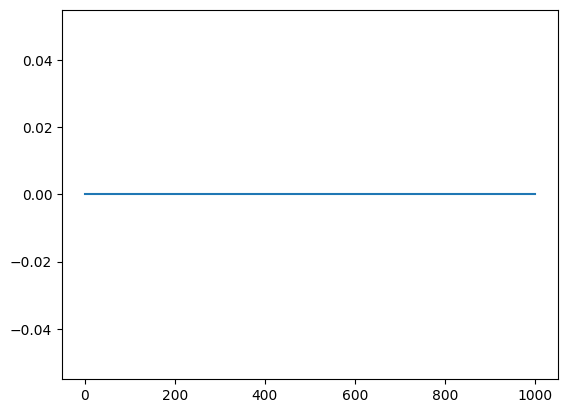

In [13]:
plt.plot(sol.ts,sol.ys[:,820])
##print(np.where(out['y'][N//2+1,:].T>0))

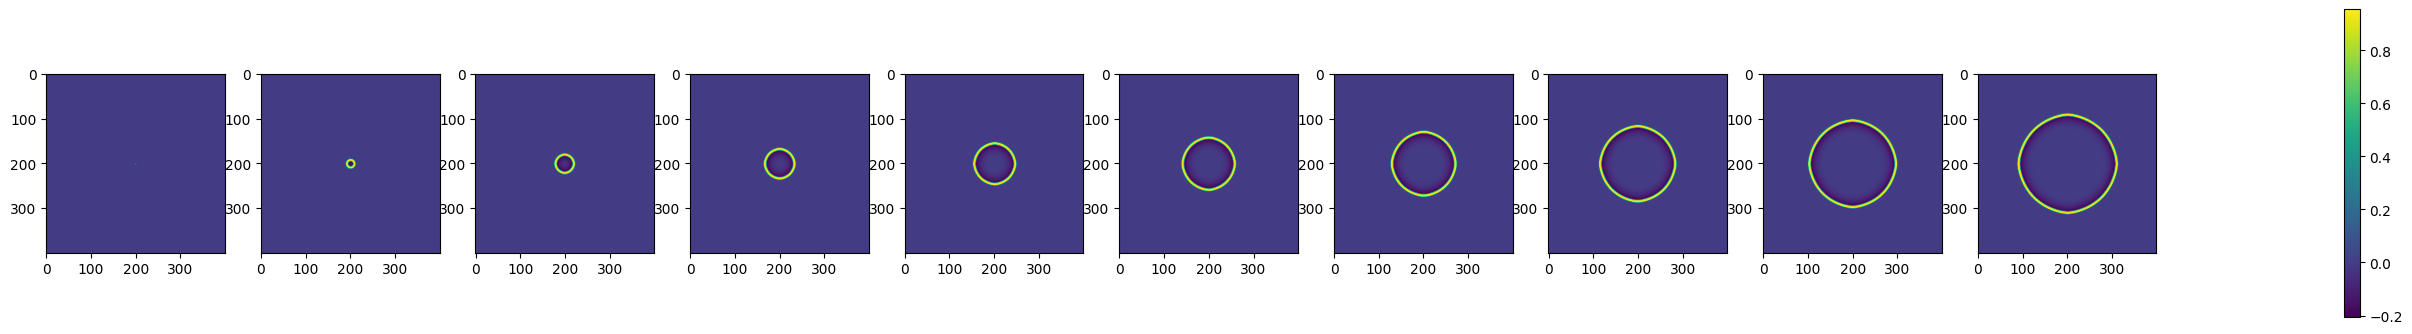

In [14]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

I guess this is quite cool cause we see the wave

## Spiral
no flux boundary condition. Excite all the left boundary, let the wave propagate up to the middle of the frame. Then initialise to zero the u variable in the lower half of the frame. The spiral should form. Otherwise, also with no flux boundary conditions we can exctite the left half of the frame, then initialise the lower half of the frame with a v variable in the refractory period. This however would require playing around with parameters.

Current problems: initialising it from a wave does not seem to work as for not too fast diffusion for some reason the wave does not reach the center of the frame. For bigger diffusion it is difficult to see anything at all. 

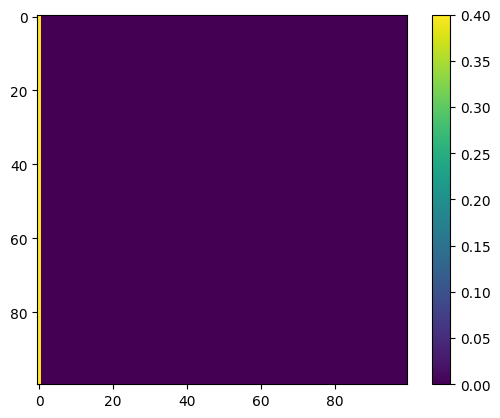

In [23]:
T = 200
plot_n = 100
N_x = 100
N_y = 100
N = N_x*N_y

y0 = np.zeros(2*N)
cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0:
        y0[i]=0.4

#y0[N//2]=0.22
L=graph_laplacian(N_x, N_y, "no-flux")
plt.imshow(y0[:N].reshape(N_x, N_y))
plt.colorbar()

In [24]:
sol = solve_heart(y0=y0,T=500)

100.00%|██████████| [00:19<00:00,  5.18%/s]


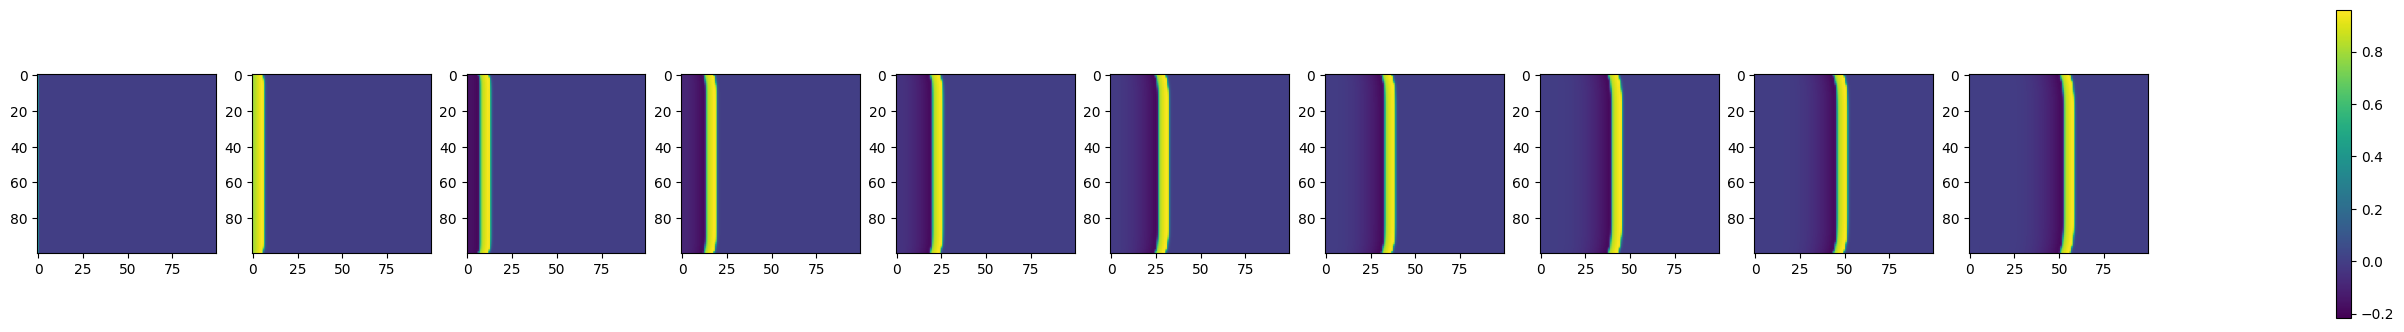

In [25]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

# 

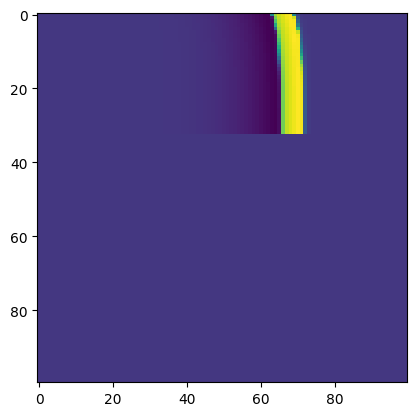

In [26]:
endstate=sol.ys[-1,:]
endu = endstate[:N].reshape(N_x, N_y)

initu = endu.at[N_y//3:, :].set(0)
plt.imshow(initu)
initu = initu.flatten()
initv = endstate[N:]
y1 = jnp.append(initu,initv)

In [27]:
sol = solve_heart(y0=y1,T=1800)

100.00%|██████████| [01:23<00:00,  1.20%/s]


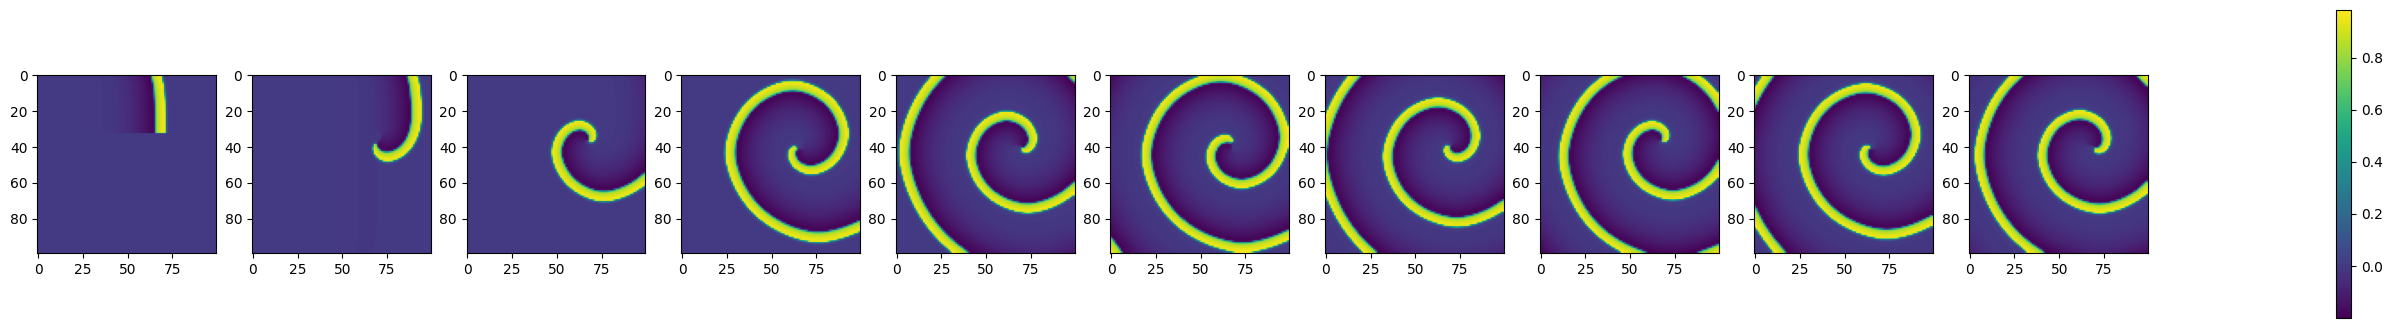

In [28]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

## Fibrillation
Apparently it is obtained by making two spirals rotating in opposite direction collide (literally this is what happens in the heart). Initialising two spiral at opposite sides of the frame should work, problems that we need a super big system and my laptop kinda refuses to carry out the simulation :)

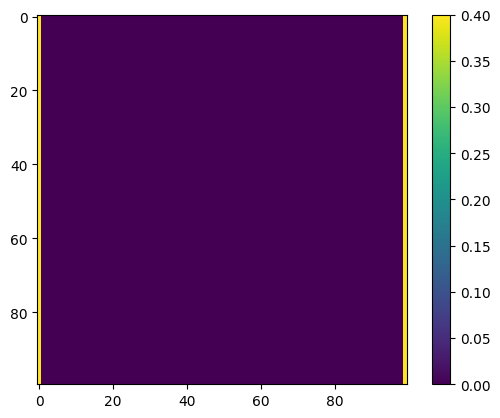

In [29]:

T = 120
plot_n = 100
N_x = 100
N_y = 100
N = N_x*N_y
y0 = np.zeros(2*N)

cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0 or i%N_x==99:
        y0[i]=0.4

#y0[N//2]=0.22
L=graph_laplacian(N_x, N_y, "no-flux")
plt.imshow(y0[:N].reshape(N_x, N_y))
plt.colorbar()

In [66]:
sol = solve_heart(y0=y0,T=200)

100.00%|██████████| [00:07<00:00, 12.86%/s]


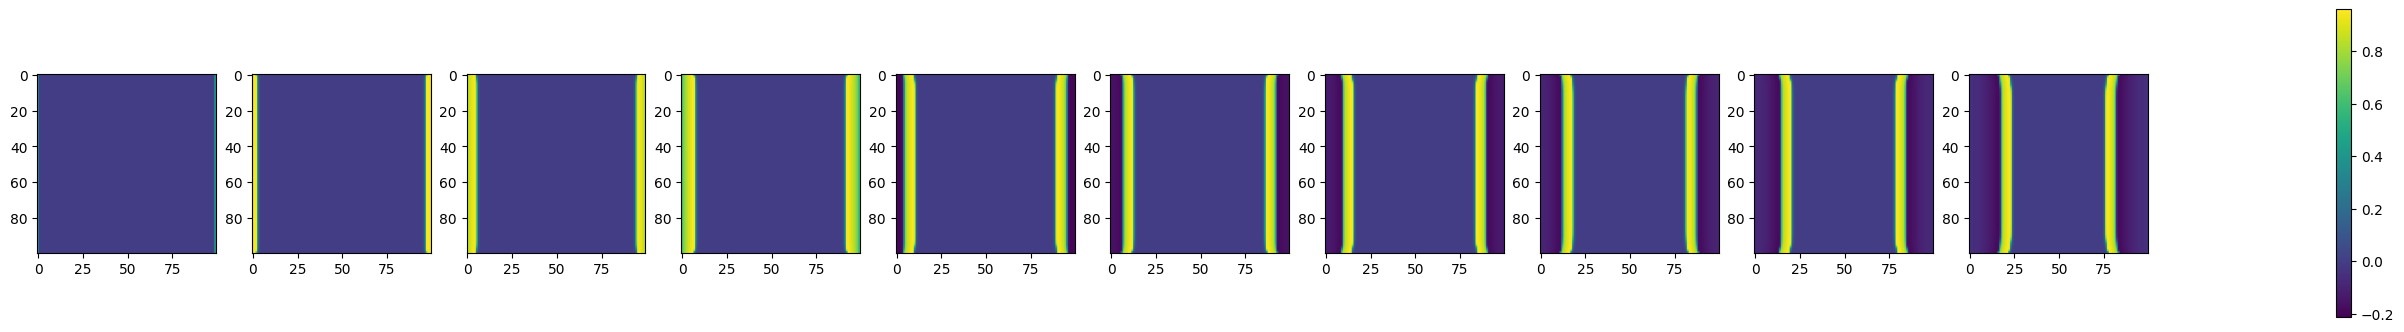

In [67]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

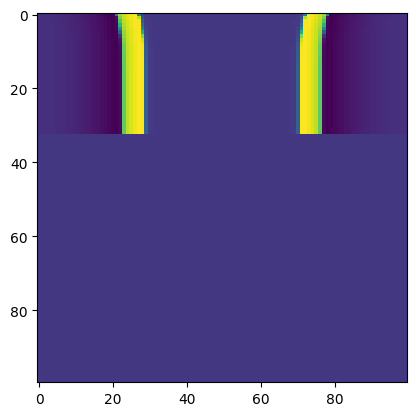

In [68]:
endstate=sol.ys[-1,:]
endu = endstate[:N].reshape(N_x, N_y)

initu = endu.at[N_y//3:, :].set(0)
plt.imshow(initu)
initu = initu.flatten()
initv = endstate[N:]
y1 = jnp.append(initu,initv)

In [69]:
sol = solve_heart(y0=y1,T=700)

100.00%|██████████| [00:27<00:00,  3.63%/s]


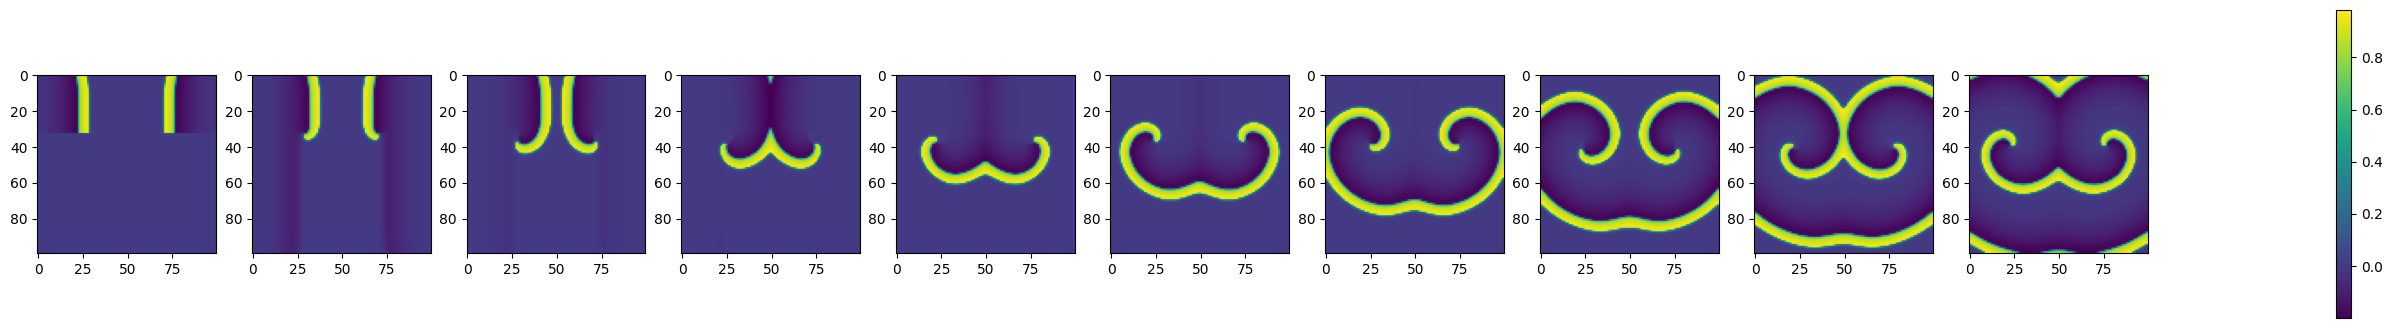

In [70]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

## Spatiotemporal chaos
it is unclear whether we can get it with FHN. Parlitz in his book uses the Aliev-Panfilov model to obtain it: 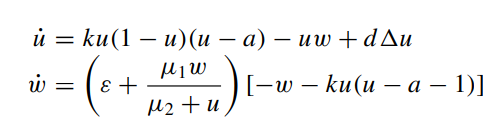
He then initialises a single spiral wave (how?) with parameters 
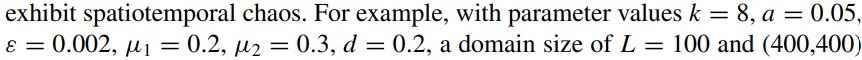

# Directed Network Coupling (🧠)

To simulate neuronal dynamics in the brain, we i) choose the coupling $G_{ij}$ to represent a directed ER graph with weak, random (but homogeneous) coupling strengths, and ii) we simulate a constant Gaussian noise $\eta_i$ for each neuron emulating the constant fluctuating input from other brain areas. 

In [15]:
import networkx as nx
import jax.random as jr
from diffrax import ControlTerm, ShARK, MultiTerm, VirtualBrownianTree
import lineax

In [17]:
#random network implementation
#if we want a ER graph: Johannes says that this is what we find in literature
# for N=10000 we should choose k=100-1000 k=mean degree
def random_graph(N, k):

    p = k / (N - 1)
    
    G = nx.erdos_renyi_graph(N, p, directed=True)
    # Random weight between 0 and 1:at the moment we stick with excitatory, then maybe we'll also
    #put inhibition. At the moment we stick with random connections with fixed weight but we could also do rd weight
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0, 1)*J 
        # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return sparse.BCSR.from_scipy_sparse(adj_matrix)

N = 10000
k = 100
c = .5
J = 0.21/(k*c)  #defines the strength of the connection. 0.21 should be the threshold for excitation
L=random_graph(N,k)


### For parameters used by FH for neuron model:
A.S. Pikovsky, J. Kurths, Coherence resonance in a noise-driven excitable system. Phys. Rev.
Lett. 78, 775–778 (1997)
### For parameters for stochastic resonance
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.78.775

Problem is that they all use a different version of FHN equations (i.e. simplifying them)

Johannes also says that for neurons we should add a time delay



In [34]:
#the FHN equations with noise and time delay
from collections import deque
u_history = deque(maxlen=5) #here I consider a time delay of 3 integration timesteps (duration AP)
#I have put noise in the fast variable as in this way we can make a parallel with an "external input"


def FHN_graph(dy, y, p, t):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]

    u_history.append(u.copy())

    # Use u from 3 time steps ago if available, otherwise use the current u
    if len(u_history) < 5:
        u_delayed = np.zeros(N)
    else:
        u_delayed = u_history[0]
    

    
    for i in range(len(dy)):
        dif = 0
        for j in range(len(u)):
            dif = L[i,j]*u[j]
        dy[i] = a*u[i]*(u[i]-b)*(1-u[i]) +dif - v[i]
        dy[i+N] = e*(u[i]-v[i])

def FHN_graph_noise(dy, y, p, t):
    dy[:N] = D
    dy[N:] = 0

T = 50
plot_n = 10

In [18]:
def FHN_graph(t, y, args):
    N, a, b, e, Du, _ = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

def FHN_graph_noise(t, y, args):
    N, _, _, _, _, Flavius = args 
    noise = Flavius*jnp.ones((2*N))
    noise = noise.at[N:].set(0)
    return lineax.DiagonalLinearOperator(noise)

In [19]:
@jax.jit
def solve_brain(y0='zeros',a=3,b=0.2,e=1e-2,Du=.1,Flavius=.1,T=300, max_steps=1000000, solver=ShARK(),rtol=1e-3, atol=1e-4,dt0=1e-2, noise_tol=1e-3):
    if y0 == 'zeros':
        y0 = jnp.zeros(2*N)
    
    deterministic_term = ODETerm(FHN_graph)
    brownian_path = VirtualBrownianTree(0, T, tol=noise_tol, shape=(2*N,), key=jr.PRNGKey(0),levy_area=diffrax.SpaceTimeLevyArea)
    noise_term = ControlTerm(FHN_graph_noise,brownian_path)
    terms = MultiTerm(deterministic_term, noise_term)

    saveat = SaveAt(ts=jnp.linspace(0, T, 1000))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    sol = diffeqsolve(terms, solver, 0, T, dt0, y0, args=(N,a,b,e,Du, Flavius), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [20]:
sol = solve_brain(T=500)

2024-10-14 12:05:30.904206: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.17 = s32[62560,16]{0,1} reduce-window(s32[62560,16]{0,1} %constant.3304, s32[] %constant.2406), window={size=1x16 pad=0_0x15_0}, to_apply=%region_19.5869

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-14 12:05:32.243142: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.3390121s
Constant folding an instruction is taking > 1s:

  %reduce-window.17 = s32[62560,16]{0,1} reduce-window(s32[62560,16]{0,1} %constant.3304, s32[] %constant.2406), window={size=1x16 pa

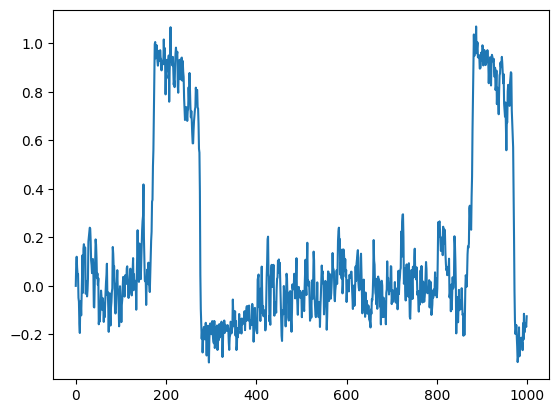

In [21]:
plt.plot(sol.ys[:,10])

In [22]:
u_sol = sol.ys[:,:N].T  # u over time
v_sol = sol.ys[:,N:].T  # v over time

### Below
with same parameters of the FHN model as the heart part

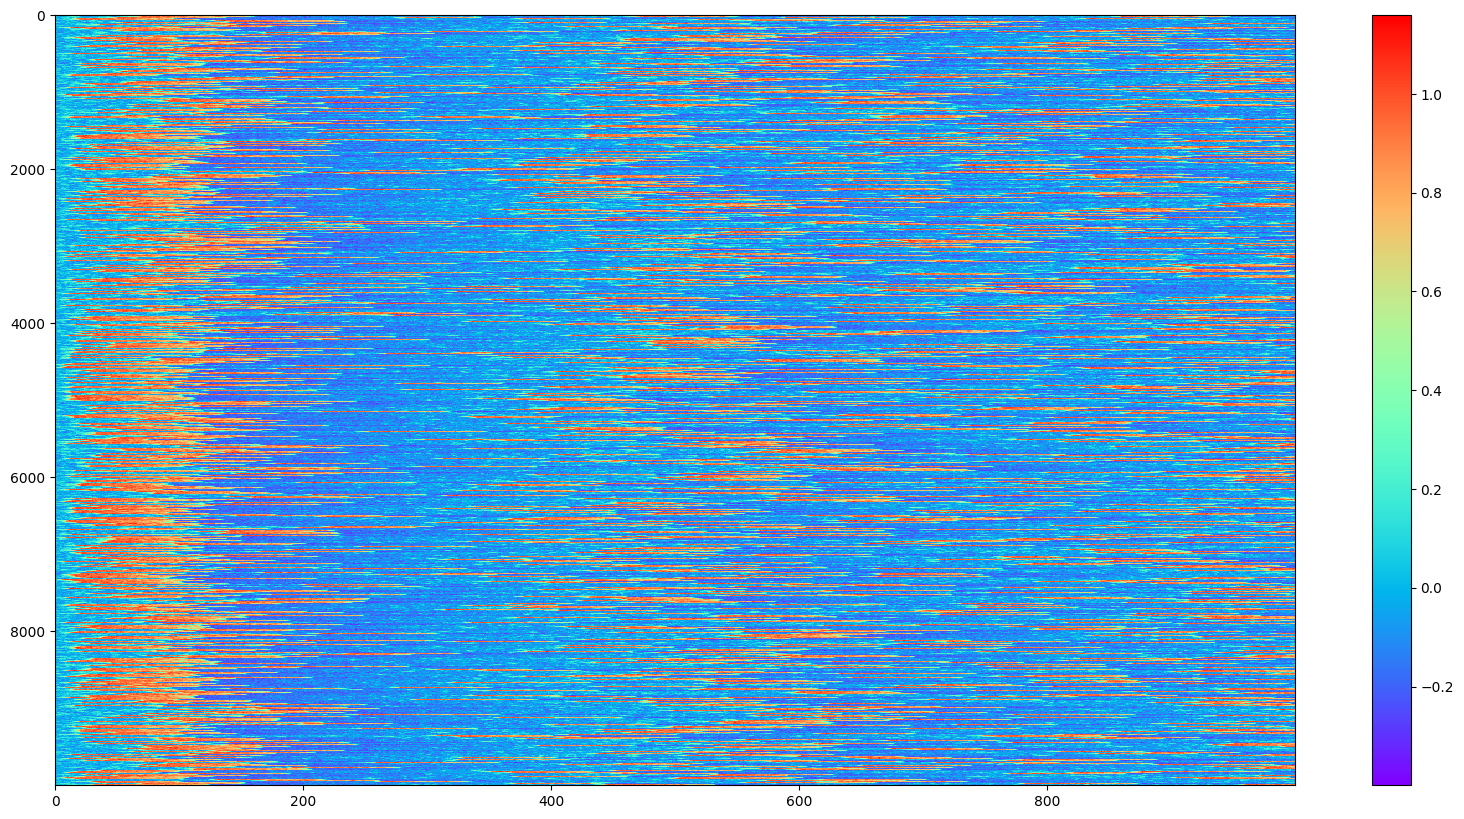

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)

### Below
with naively implemented time delay

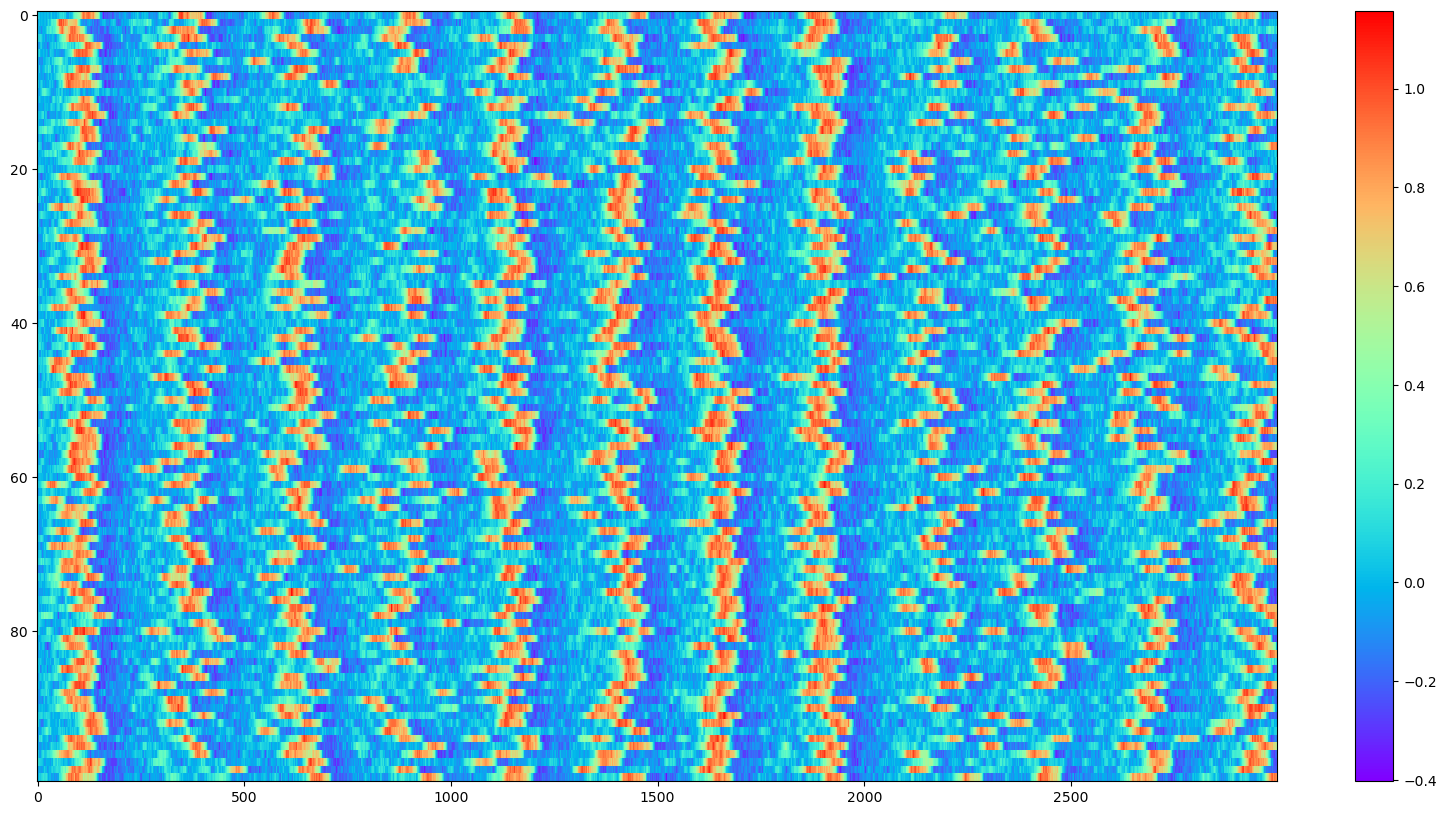

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)


## Below:
without any time delay

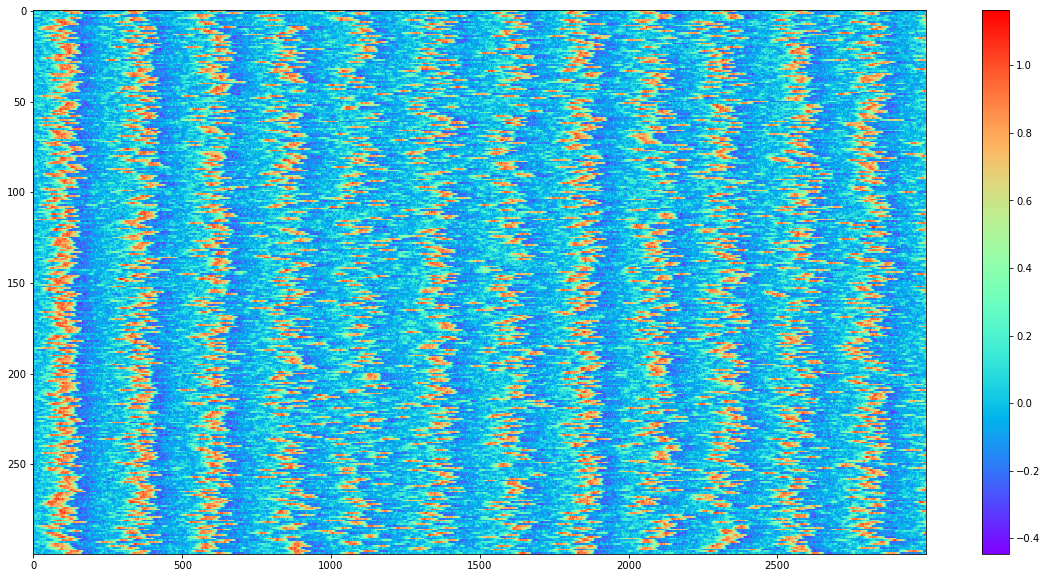

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)


## Below: without coupling

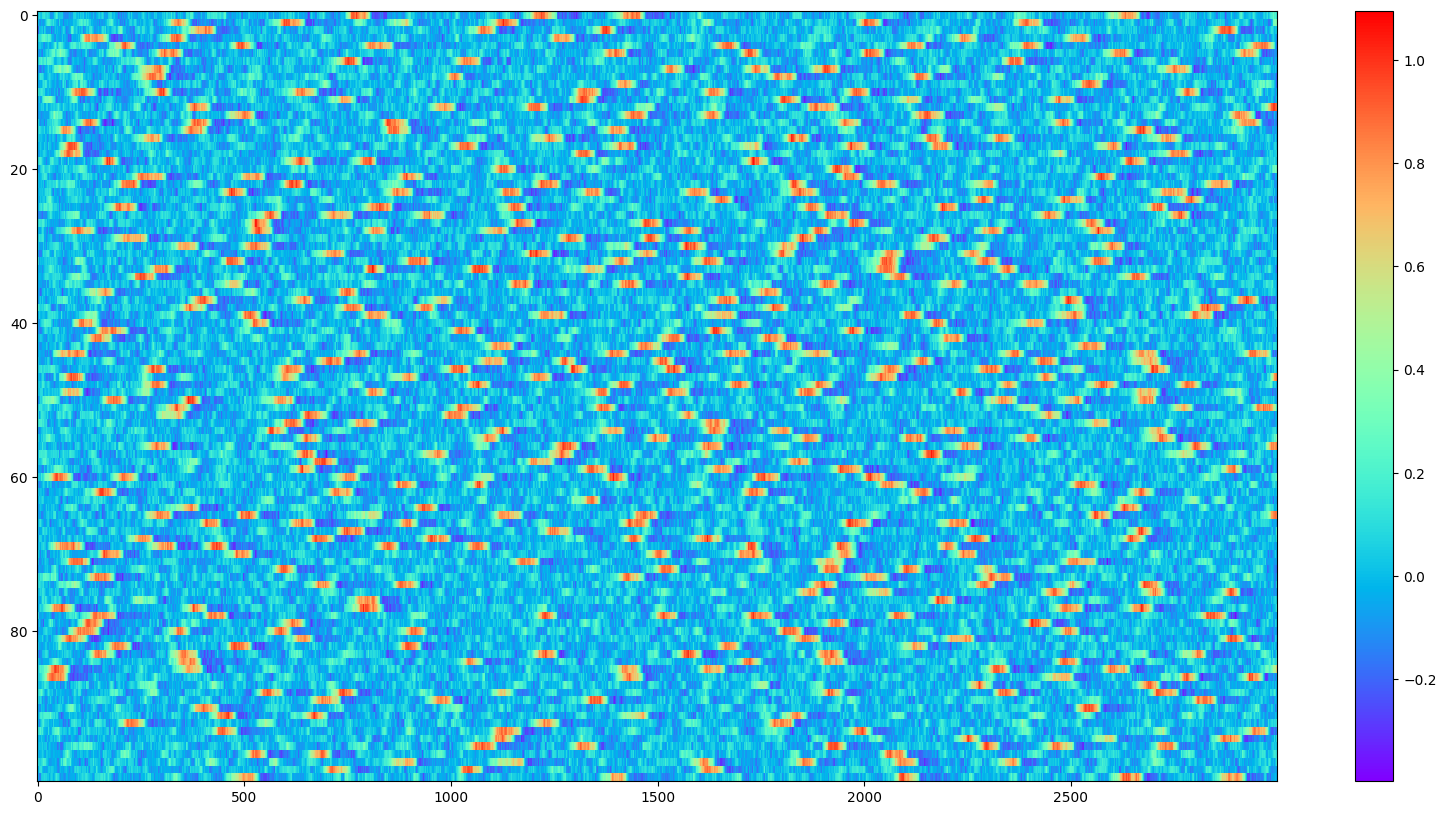

In [324]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)